# Homework 04: Building CNNs for Image Classification

## Due: Midnight on September 28 (with 2-hour grace period) and worth 85 points

In this assignment, you will take your first steps into designing and training convolutional neural networks (CNNs) for image classification. Starting from a simple baseline, you will experiment with modifications that reflect the kinds of design choices practitioners face every day. Along the way, you’ll see how architecture, hyperparameters, normalization, pooling strategies, and learning rate schedules can each shape a model’s performance.

The problems are organized to build on each other:

1. **Hyperparameters:** Begin with a baseline CNN and try variations in learning rate, layer width, depth, and dropout.
2. **Batch Normalization:** Add normalization after convolutional layers to stabilize training and speed convergence.
3. **Global Average Pooling:** Replace the flatten-and-dense head with a modern pooling layer, reducing parameters and improving generalization.
4. **ReduceLROnPlateau:** Explore a widely used learning rate scheduler that adapts when validation progress slows.
5. **Very Deep CNN:** Finally, run a VGG-16–style model to observe how deeper networks behave compared to smaller ones.

By the end of this homework, you will have hands-on experience with both classical and modern CNN design strategies, a sense of how different components affect learning, and a toolkit of techniques that will serve you in future image processing projects.

There are 10 graded questions, worth 8 points each, with 5 points free if you complete the homework.


## 1. Setup and Data Loading


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os,time,random,kagglehub

import tensorflow as tf
from tensorflow.keras import layers, Input, models, callbacks, regularizers,initializers
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.optimizers import Adam,AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,MaxPooling2D,Conv2D,SeparableConv2D,GlobalAveragePooling2D,GlobalMaxPooling2D,BatchNormalization

from sklearn.model_selection import train_test_split

# utility code

# -------------------------
# Reproducibility settings
# -------------------------

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [2]:

def plot_learning_curves(hist, title, verbose=True):

    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(),
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- `X_train,y_train,X_val,y_val,X_test,y_test` already defined, accessed here as global variables

In [3]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model,
                   epochs        = 500,                   # Just needs to be bigger than early stopping point
                   lr_schedule   = 1e-3,                  # Adam default
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 128,
                   use_early_stopping = True,
                   patience      = 10,
                   min_delta     = 0.0001,
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule)
    else:
        opt = optimizer

    #Compiling the model
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )


    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()

    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]

    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")

    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the Intel Image Classification Dataset  



In [4]:
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

Using Colab cache for faster access to the 'intel-image-classification' dataset.


In [5]:
# Reproducible load + preprocess for Intel Image Classification

# -------------------------
# Loader (deterministic)
# -------------------------
def load_data_from_directory(directory, img_size=(150, 150), class_names=None):
    """
    Loads images as float32 in [0,1] and integer labels.
    Sorting ensures deterministic order. If class_names is provided,
    that ordering defines label indices.
    Returns: X, y, class_names_used
    """
    if class_names is None:
        class_names = sorted(
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d))
        )
    else:
        # Ensure only classes present in directory are used (robustness)
        class_names = [c for c in class_names if os.path.isdir(os.path.join(directory, c))]

    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    X, y = [], []
    for class_name in class_names:
        folder = os.path.join(directory, class_name)
        # Sort filenames so load order is reproducible
        for fname in sorted(os.listdir(folder)):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            img_path = os.path.join(folder, fname)
            # Explicit interpolation for consistency
            img = load_img(img_path, target_size=img_size, interpolation="bilinear")
            arr = img_to_array(img)  # float32
            X.append(arr)
            y.append(class_to_idx[class_name])

    X = (np.array(X, dtype="float32") / 255.0)   # normalize to [0,1]
    y = np.array(y, dtype="int32")               # integer labels
    return X, y, class_names

def show_counts(name, y_arr):
    c = Counter(y_arr.tolist() if hasattr(y_arr, "tolist") else y_arr)
    print(f"{name} per-class counts:", dict(c))

# -------------------------
# Download & paths
# -------------------------
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

# -------------------------
# Load train (get class_names) & test using same mapping
# -------------------------
X_train_all, y_train_all, class_names = load_data_from_directory(train_dir, img_size=(150,150))
X_test,       y_test,   _            = load_data_from_directory(test_dir, img_size=(150,150), class_names=class_names)

num_classes = len(class_names)
print("class_names:", class_names)
print("X_train_all:", X_train_all.shape, "y_train_all:", y_train_all.shape)
print("X_test:     ", X_test.shape,      "y_test:     ", y_test.shape)

# -------------------------
# Stratified train/val split (reproducible)
# -------------------------

X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all,
    test_size=0.2,
    stratify=y_train_all,
    random_state=random_seed,
    shuffle=True
)

Using Colab cache for faster access to the 'intel-image-classification' dataset.
class_names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
X_train_all: (14034, 150, 150, 3) y_train_all: (14034,)
X_test:      (3000, 150, 150, 3) y_test:      (3000,)


### Examine The Dataset

In [6]:
print("X_train:",  X_train.shape,  "y_train:",  y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

X_train: (11227, 150, 150, 3) y_train: (11227,)
X_val: (2807, 150, 150, 3) y_val: (2807,)
train per-class counts: {0: 1753, 4: 1819, 2: 1923, 1: 1817, 5: 1906, 3: 2009}
val   per-class counts: {1: 454, 2: 481, 3: 503, 0: 438, 4: 455, 5: 476}
test  per-class counts: {0: 437, 1: 474, 2: 553, 3: 525, 4: 510, 5: 501}


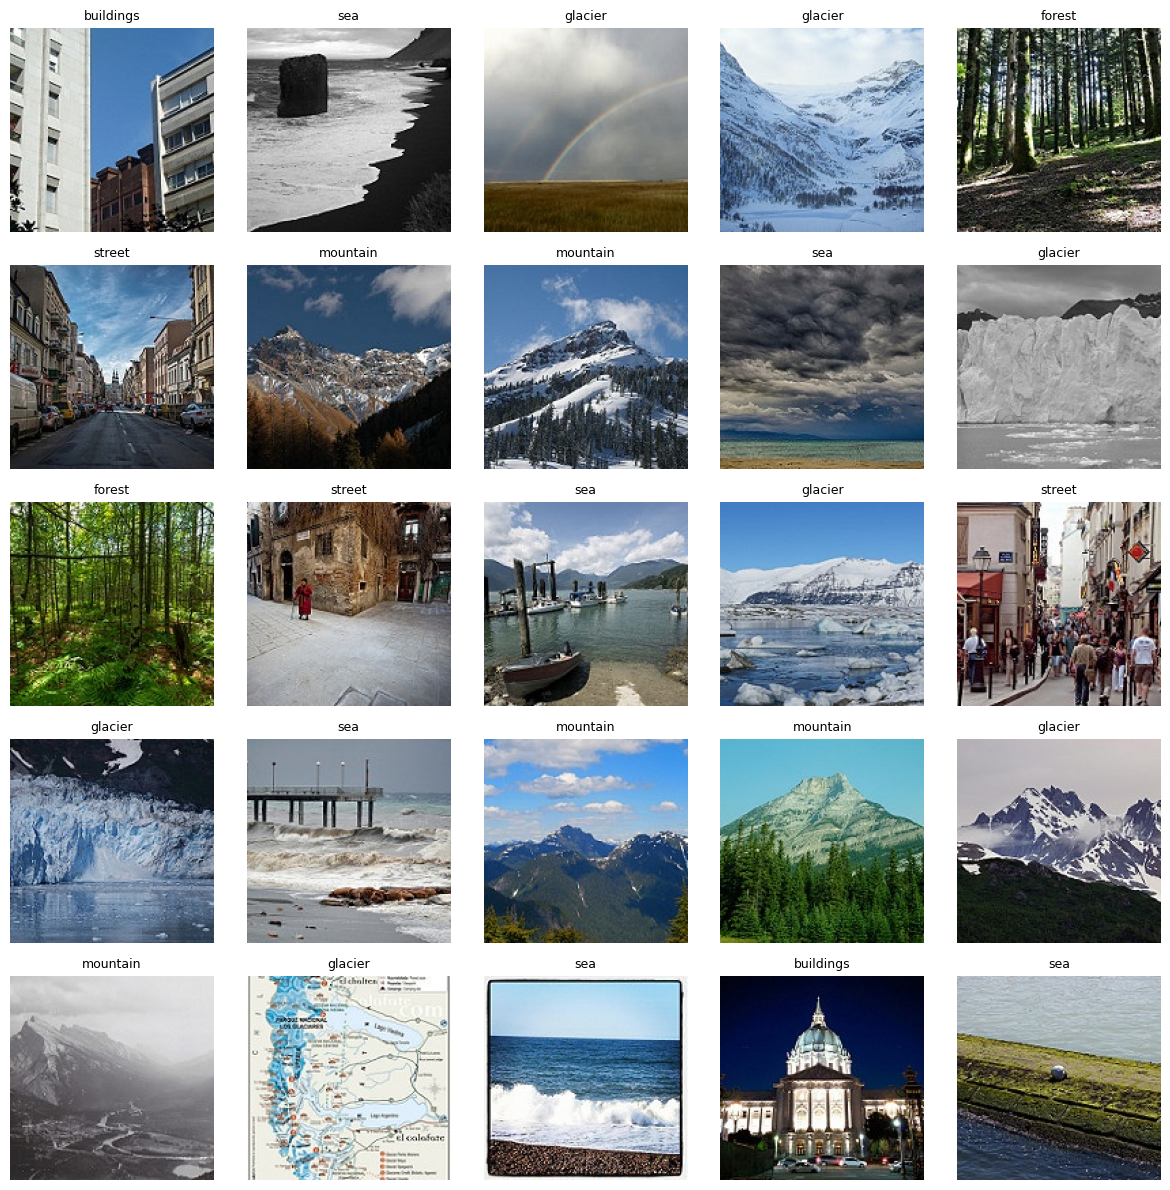

In [7]:
# Show a 5×5 grid of the first 25 training images
plt.figure(figsize=(12, 12))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    # X_train is already a NumPy array [0–1], so no .numpy() needed
    plt.imshow(X_train[i])
    # pick the class name from your class_names list
    plt.title(class_names[y_train[i]], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


### Prelude: Baseline CNN (reference model)

This is our **reference** network: two Conv→Pool blocks with channels **32 → 64**, followed by a **single hidden head** `Dense(64)`. We use **He** initialization for ReLU activations and include an **optional `Dropout(0.5)`** to illustrate regularization—comment it out to gauge its impact (ha, not really optional!).

Use this model as a stable yardstick while you run **ablations**: change **one knob at a time** (e.g., widen/deepen the conv blocks, adjust dropout rate, add batch norm, tweak the LR schedule) and compare results back to this baseline. Focus on **training vs. validation curves**, the **generalization gap**, and how dropout affects **val loss/accuracy** and how long it takes for Early Stopping to kick in.



Baseline Model



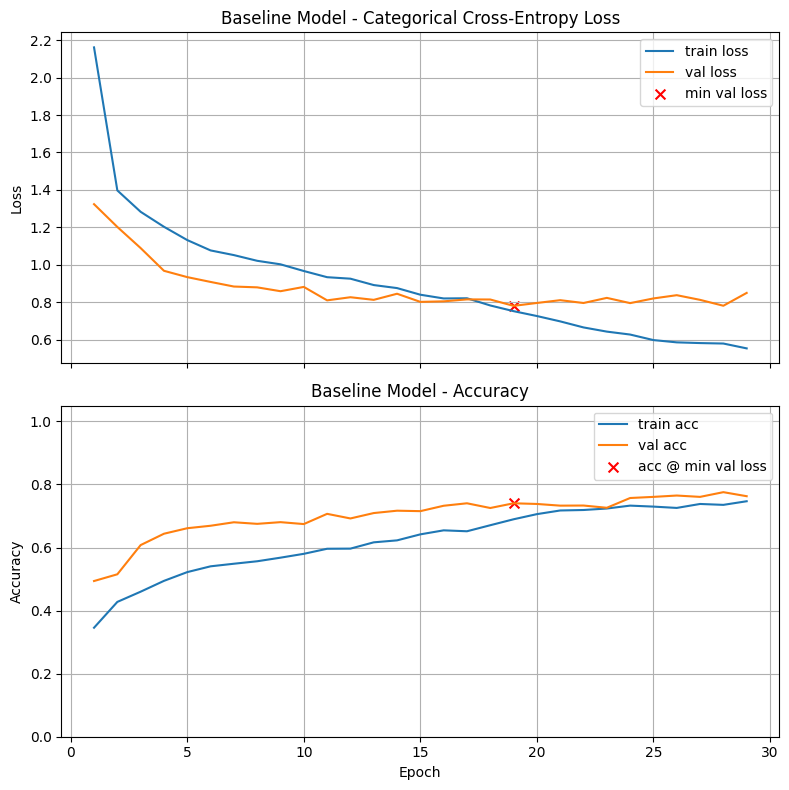

Final Training Loss:            0.5528
Final Training Accuracy:        0.7468
Final Validation Loss:          0.8492
Final Validation Accuracy:      0.7627
Minimum Validation Loss:        0.7800 (Epoch 19)
Validation Accuracy @ Min Loss: 0.7403

Test Loss: 0.7888
Test Accuracy: 0.7290

Validation-Test Gap (accuracy): 0.011292

Execution Time: 00:01:23


In [8]:
he = initializers.HeNormal()                                # best initializer for relu

model_baseline= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_baseline,title="Baseline Model")


## Problem One: Exploring Basic Hyperparameters

**Task:**
Copy the baseline CNN model into the next cell and experiment with basic hyperparameter changes. Your goal is to see whether small tweaks can improve validation accuracy (and hopefully speed up convergence or produce smoother training curves). You must **pick 3 of the following tweaks** and investigate their effect:

**Tweaks to Try:**

1. Adjust the learning rate (default for Adam is `1e-3`).
2. Change the width of the `Conv2D` layers (e.g., 64 → 128).
3. Add an extra `Conv2D` layer (e.g., stack 32 → 64 → 128).
4. Change the width of the `Dense(64 ...)` layer.
5. Add L2 regularization to the `Dense(64 ...)` layer (see the head of the network in Problem 5 for inspiration).  
6. Modify the dropout rate.
   
Observe the effect of each of your 3 choices in isolation and answer the graded questions.

**Optional:**
Combine two or more changes to see if they work together to improve results (example: try L2 regularization and reduced dropout in the head, as in Problem 5).


**Pro Tip:** Give each experiment a descriptive title, such as "Problem 1 -- Tweak 1 -- lr: 0.0005" to keep track of your experiments (see last cell in the notebook).


Problem 1 -- Tweak 1.1 -- lr: 1e-4



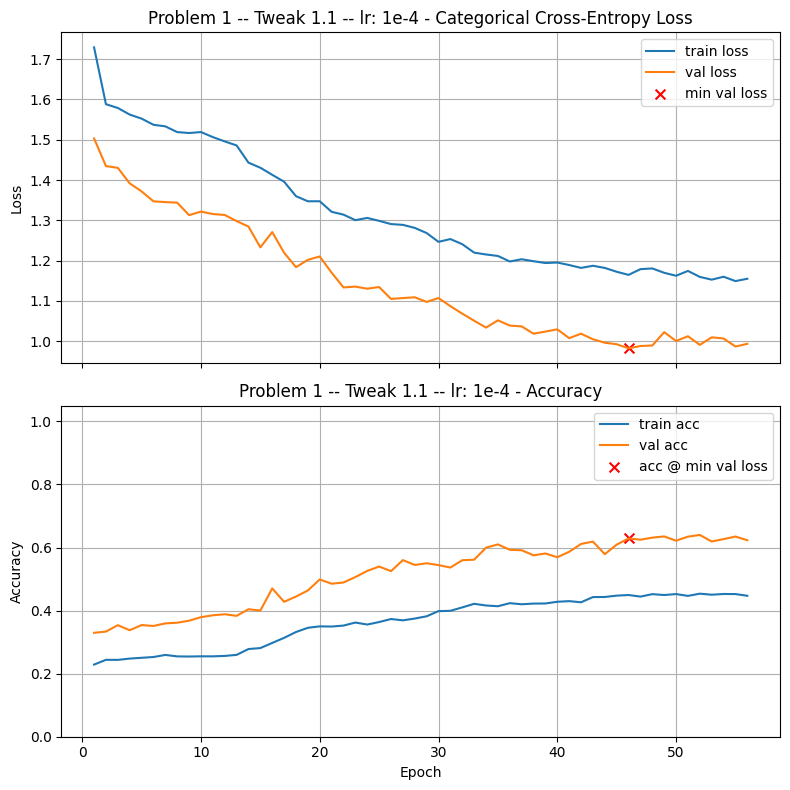

Final Training Loss:            1.1548
Final Training Accuracy:        0.4470
Final Validation Loss:          0.9933
Final Validation Accuracy:      0.6231
Minimum Validation Loss:        0.9819 (Epoch 46)
Validation Accuracy @ Min Loss: 0.6288

Test Loss: 0.9919
Test Accuracy: 0.6217

Validation-Test Gap (accuracy): 0.007119

Execution Time: 00:02:10


In [9]:
# Your code here, add additional cells if you wish

# Adjusting learning rate

he = initializers.HeNormal()                                # best initializer for relu

model_lr1= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_lr1, lr_schedule=1e-4, title="Problem 1 -- Tweak 1.1 -- lr: 1e-4")


Problem 1 -- Tweak 1.2 -- lr: 1e-5



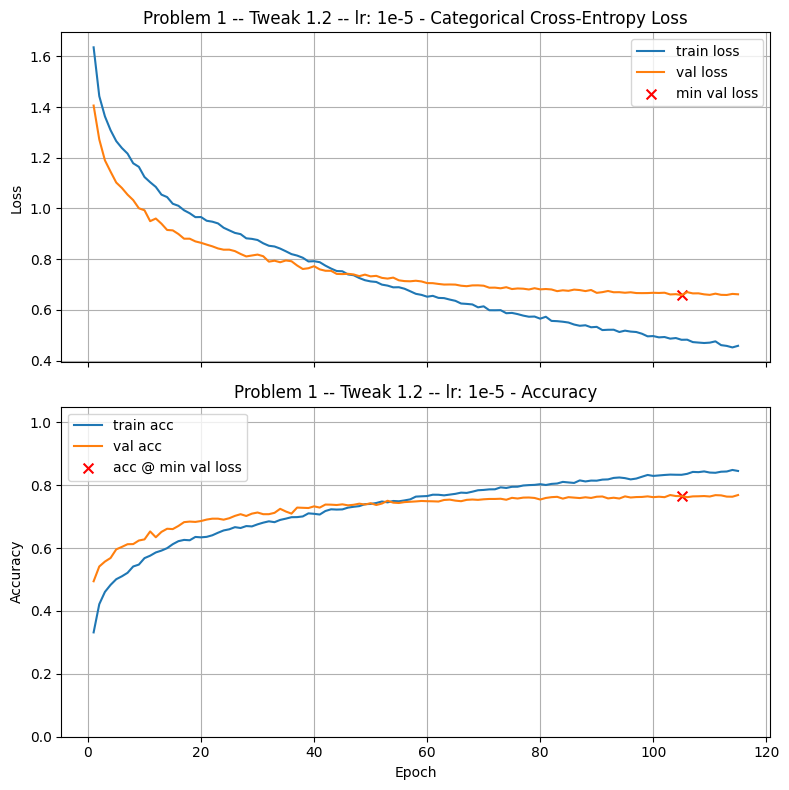

Final Training Loss:            0.4580
Final Training Accuracy:        0.8454
Final Validation Loss:          0.6613
Final Validation Accuracy:      0.7688
Minimum Validation Loss:        0.6582 (Epoch 105)
Validation Accuracy @ Min Loss: 0.7652

Test Loss: 0.6632
Test Accuracy: 0.7677

Validation-Test Gap (accuracy): 0.002437

Execution Time: 00:04:14


In [10]:
# Adjusting learning rate

he = initializers.HeNormal()                                # best initializer for relu

model_lr2 = models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_lr2, lr_schedule=1e-5, title="Problem 1 -- Tweak 1.2 -- lr: 1e-5")


Problem 1 -- Tweak 2 -- Changing Conv2D widths



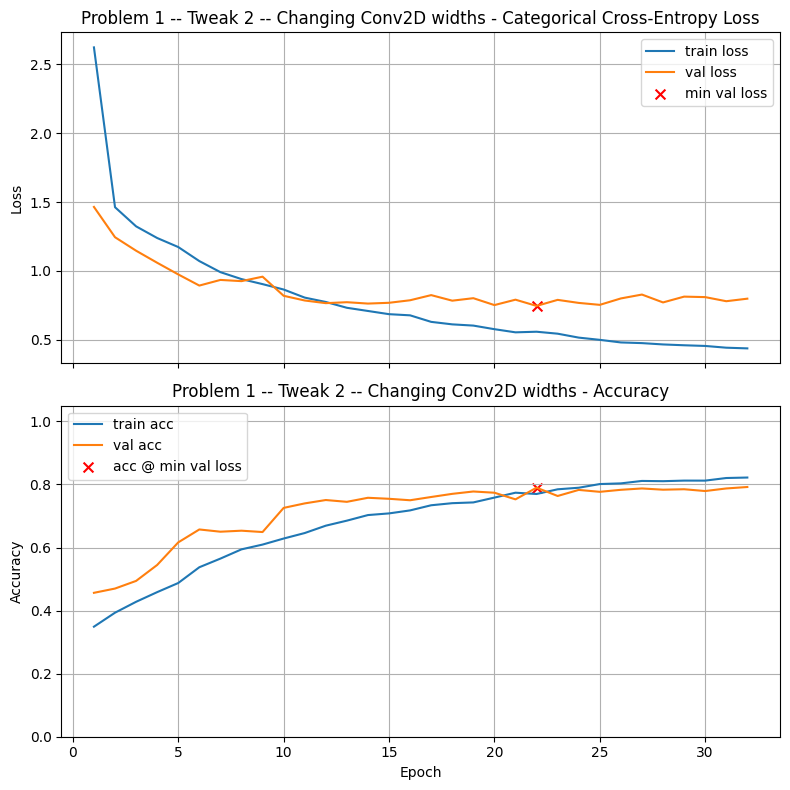

Final Training Loss:            0.4384
Final Training Accuracy:        0.8219
Final Validation Loss:          0.7990
Final Validation Accuracy:      0.7919
Minimum Validation Loss:        0.7465 (Epoch 22)
Validation Accuracy @ Min Loss: 0.7898

Test Loss: 0.7279
Test Accuracy: 0.7890

Validation-Test Gap (accuracy): 0.000811

Execution Time: 00:01:58


In [11]:
# Changing Conv2D width

he = initializers.HeNormal()                                # best initializer for relu

model_conwidth= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_conwidth,title="Problem 1 -- Tweak 2 -- Changing Conv2D widths")


Problem 1 -- Tweak 3 -- Adding an extra Conv2D layer



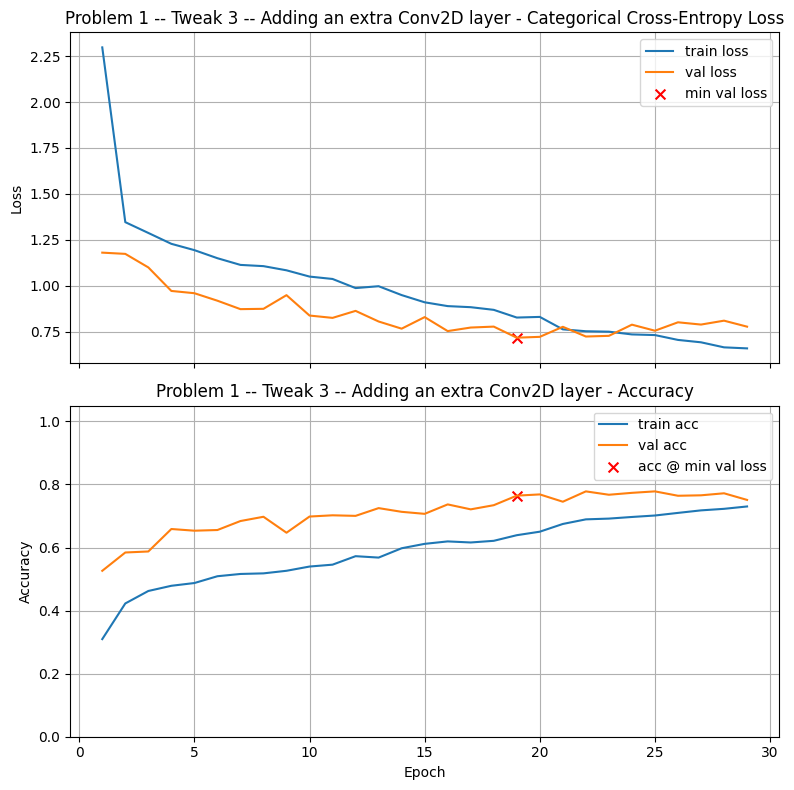

Final Training Loss:            0.6588
Final Training Accuracy:        0.7302
Final Validation Loss:          0.7771
Final Validation Accuracy:      0.7510
Minimum Validation Loss:        0.7170 (Epoch 19)
Validation Accuracy @ Min Loss: 0.7645

Test Loss: 0.7162
Test Accuracy: 0.7640

Validation-Test Gap (accuracy): 0.000517

Execution Time: 00:01:21


In [12]:
# Adding an extra Conv2D layer

he = initializers.HeNormal()                                # best initializer for relu

model_xtracon= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_xtracon,title="Problem 1 -- Tweak 3 -- Adding an extra Conv2D layer")


Problem 1 -- Tweak 4.1 -- Dense: 32



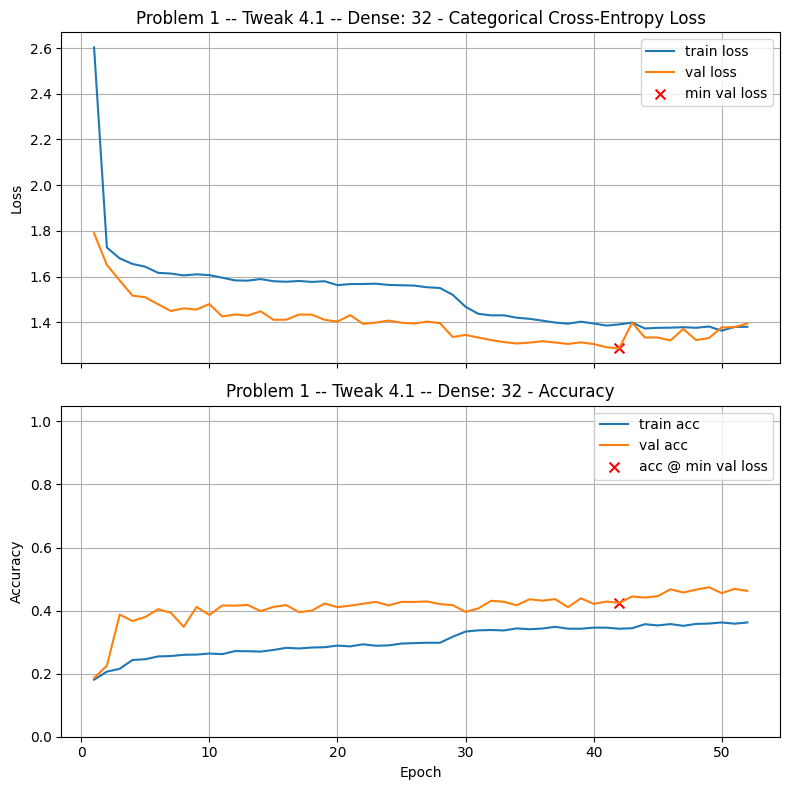

Final Training Loss:            1.3805
Final Training Accuracy:        0.3623
Final Validation Loss:          1.3953
Final Validation Accuracy:      0.4624
Minimum Validation Loss:        1.2861 (Epoch 42)
Validation Accuracy @ Min Loss: 0.4247

Test Loss: 1.2829
Test Accuracy: 0.4317

Validation-Test Gap (accuracy): 0.007014

Execution Time: 00:02:03


In [13]:
# Changing width of Dense layer

he = initializers.HeNormal()                                # best initializer for relu

model_dense1= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(32, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_dense1,title="Problem 1 -- Tweak 4.1 -- Dense: 32")


Problem 1 -- Tweak 4.2 -- Dense: 16



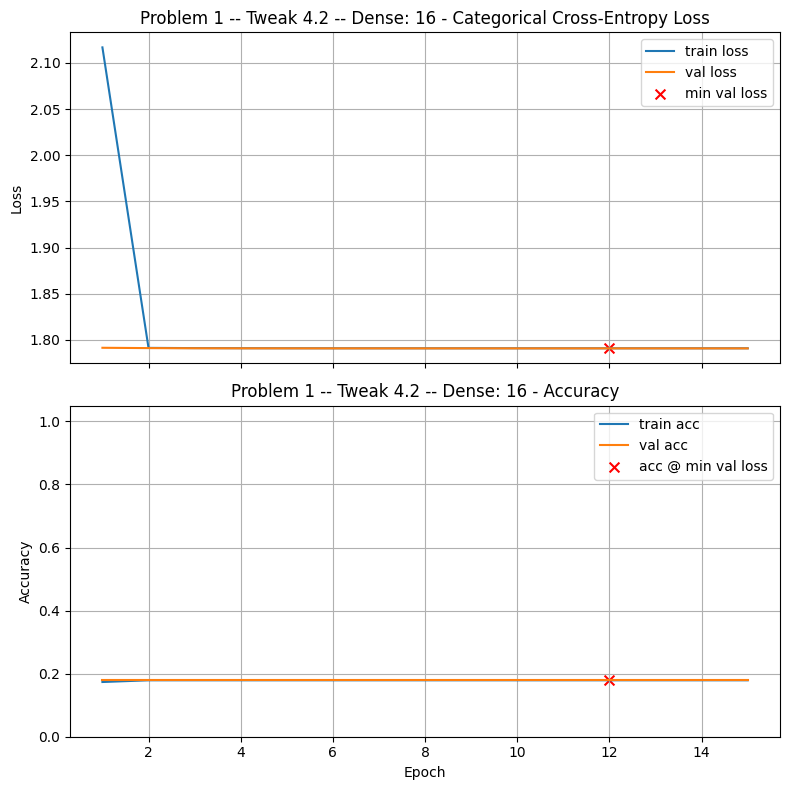

Final Training Loss:            1.7908
Final Training Accuracy:        0.1789
Final Validation Loss:          1.7907
Final Validation Accuracy:      0.1792
Minimum Validation Loss:        1.7907 (Epoch 12)
Validation Accuracy @ Min Loss: 0.1792

Test Loss: 1.7903
Test Accuracy: 0.1750

Validation-Test Gap (accuracy): 0.004195

Execution Time: 00:00:46


In [14]:
# Changing width of Dense layer

he = initializers.HeNormal()                                # best initializer for relu

model_dense2= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(16, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_dense2,title="Problem 1 -- Tweak 4.2 -- Dense: 16")


Problem 1 -- Tweak 4.3 -- Dense: 128



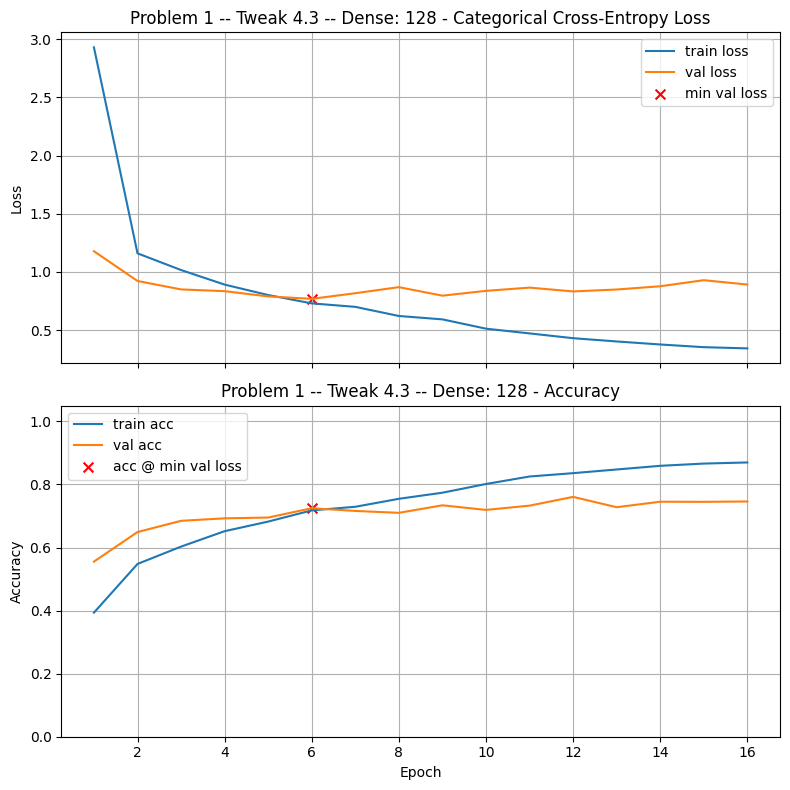

Final Training Loss:            0.3433
Final Training Accuracy:        0.8698
Final Validation Loss:          0.8919
Final Validation Accuracy:      0.7460
Minimum Validation Loss:        0.7691 (Epoch 6)
Validation Accuracy @ Min Loss: 0.7246

Test Loss: 0.7683
Test Accuracy: 0.7237

Validation-Test Gap (accuracy): 0.000950

Execution Time: 00:00:51


In [15]:
# Changing width of Dense layer

he = initializers.HeNormal()                                # best initializer for relu

model_dense3= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(128, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_dense3,title="Problem 1 -- Tweak 4.3 -- Dense: 128")


Problem 1 -- Tweak 5.1 -- L2 Reg: 1e-4



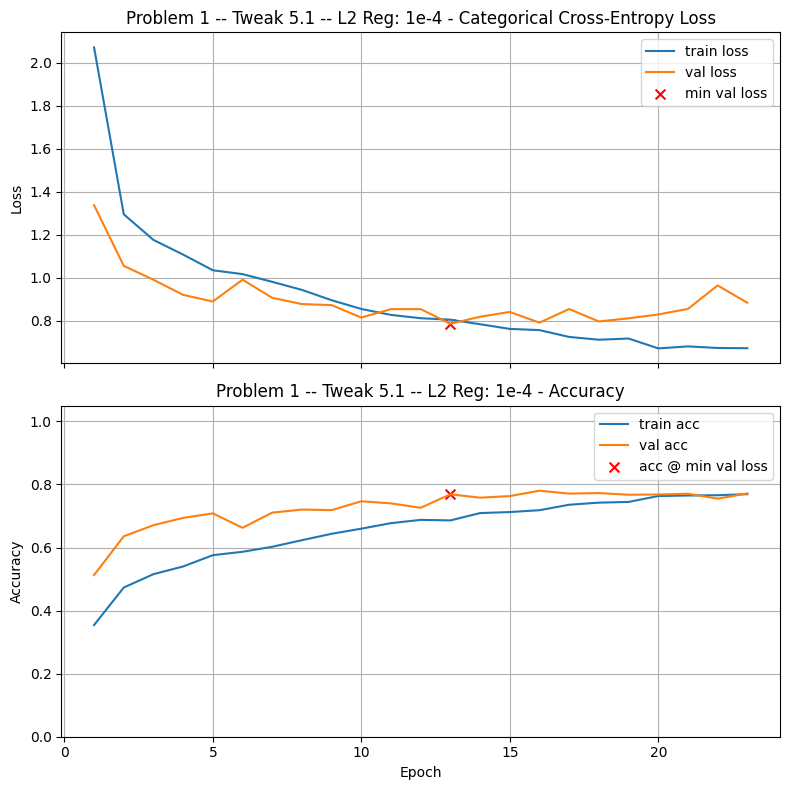

Final Training Loss:            0.6719
Final Training Accuracy:        0.7692
Final Validation Loss:          0.8835
Final Validation Accuracy:      0.7716
Minimum Validation Loss:        0.7857 (Epoch 13)
Validation Accuracy @ Min Loss: 0.7688

Test Loss: 0.7772
Test Accuracy: 0.7640

Validation-Test Gap (accuracy): 0.004792

Execution Time: 00:01:01


In [16]:
# Adding L2 regularization

he = initializers.HeNormal()                                # best initializer for relu
l2reg = regularizers.l2(1e-4)

model_l2reg1= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he, kernel_regularizer=l2reg),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_l2reg1,title="Problem 1 -- Tweak 5.1 -- L2 Reg: 1e-4")


Problem 1 -- Tweak 5.2 -- L2 Reg: 3e-5



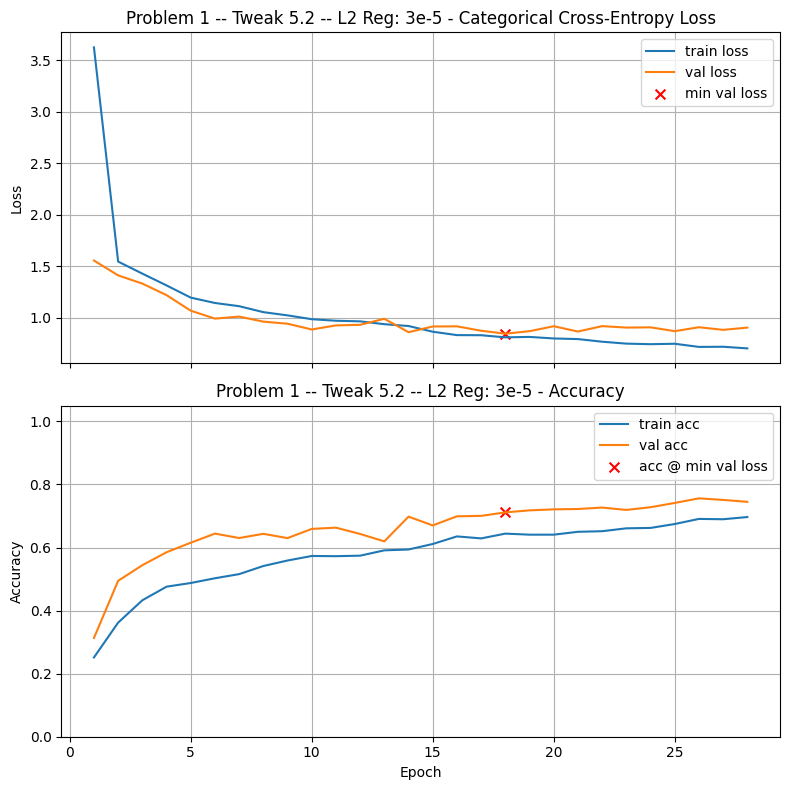

Final Training Loss:            0.7039
Final Training Accuracy:        0.6967
Final Validation Loss:          0.9055
Final Validation Accuracy:      0.7449
Minimum Validation Loss:        0.8463 (Epoch 18)
Validation Accuracy @ Min Loss: 0.7114

Test Loss: 0.8418
Test Accuracy: 0.7230

Validation-Test Gap (accuracy): 0.011564

Execution Time: 00:01:11


In [17]:
# Adding L2 regularization

he = initializers.HeNormal()                                # best initializer for relu
l2reg = regularizers.l2(3e-5)

model_l2reg2= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he, kernel_regularizer=l2reg),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_l2reg2,title="Problem 1 -- Tweak 5.2 -- L2 Reg: 3e-5")


Problem 1 -- Tweak 6 -- Dropout: 0.3



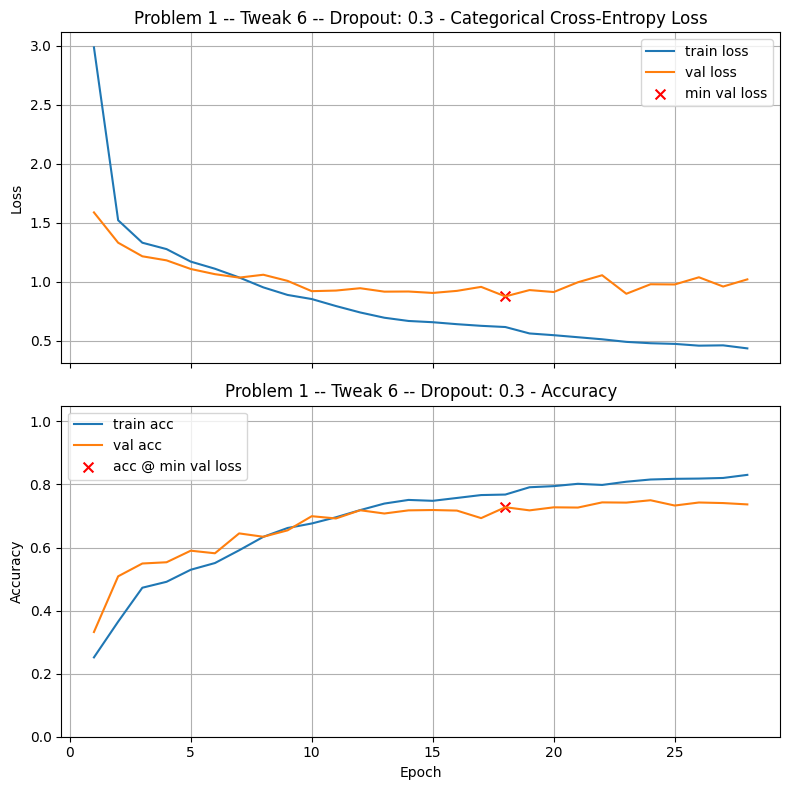

Final Training Loss:            0.4367
Final Training Accuracy:        0.8304
Final Validation Loss:          1.0208
Final Validation Accuracy:      0.7367
Minimum Validation Loss:        0.8766 (Epoch 18)
Validation Accuracy @ Min Loss: 0.7278

Test Loss: 0.9054
Test Accuracy: 0.7233

Validation-Test Gap (accuracy): 0.004490

Execution Time: 00:01:11


In [18]:
# Modify dropout

he = initializers.HeNormal()                                # best initializer for relu

model_dropout= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_dropout,title="Problem 1 -- Tweak 6 -- Dropout: 0.3")

In [19]:
print_results()

Problem 1 -- Tweak 2 -- Changing Conv2D widths	0.7898	22
Problem 1 -- Tweak 5.1 -- L2 Reg: 1e-4  	0.7688	13
Problem 1 -- Tweak 1.2 -- lr: 1e-5      	0.7652	105
Problem 1 -- Tweak 3 -- Adding an extra Conv2D layer	0.7645	19
Baseline Model                          	0.7403	19
Problem 1 -- Tweak 6 -- Dropout: 0.3    	0.7278	18
Problem 1 -- Tweak 4.3 -- Dense: 128    	0.7246	6
Problem 1 -- Tweak 5.2 -- L2 Reg: 3e-5  	0.7114	18
Problem 1 -- Tweak 1.1 -- lr: 1e-4      	0.6288	46
Problem 1 -- Tweak 4.1 -- Dense: 32     	0.4247	42
Problem 1 -- Tweak 4.2 -- Dense: 16     	0.1792	12


### Graded Questions

In [20]:
# Set a1a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 2             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [21]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1a = {a1a}')


a1a = 2


In [22]:
# Set a1b to the validation accuracy found by the choice specified in Question a1a.

a1b = 0.7898             # Replace 0.0 with your answer

In [23]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1b = {a1b:.4f}')

a1b = 0.7898


## Problem Two: Adding Batch Normalization

**Task:**
Take your best model from Problem One and add a `BatchNormalization()` layer immediately after each `Conv2D` layer. Batch normalization helps stabilize training and can improve convergence.

**Next Steps:**

* Train the model with batch normalization included after each `Conv2D` layer.
* Try at least one of tweaks from Problem 1 to see if you can improve your results in this new design.
* Compare the results to your earlier experiments and answer the graded questions.

**Optional:**
Try more than one hyperparameter change alongside batch normalization and see how they interact.




Problem 2 -- Baseline Batch Normalization



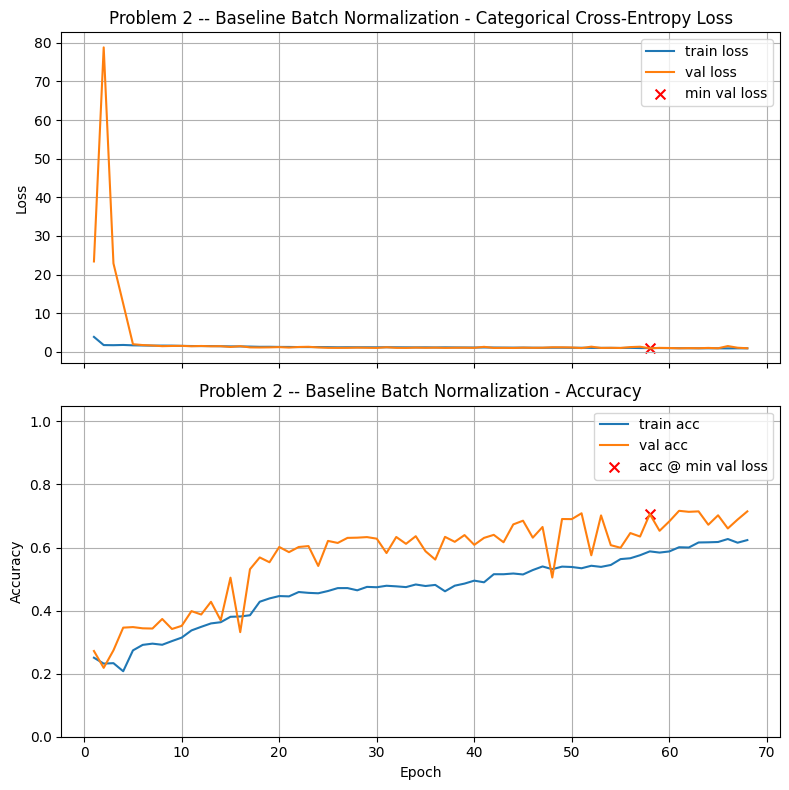

Final Training Loss:            0.8910
Final Training Accuracy:        0.6236
Final Validation Loss:          0.9120
Final Validation Accuracy:      0.7146
Minimum Validation Loss:        0.8997 (Epoch 58)
Validation Accuracy @ Min Loss: 0.7061

Test Loss: 0.8642
Test Accuracy: 0.7177

Validation-Test Gap (accuracy): 0.011575

Execution Time: 00:04:08


In [24]:
# Your code here, add additional cells if you wish

# Batch Normalization Baseline

he = initializers.HeNormal()                                # best initializer for relu

model_batch_base= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_batch_base,title="Problem 2 -- Baseline Batch Normalization")


Problem 2 -- Tweak 1 -- LR: 1e-4



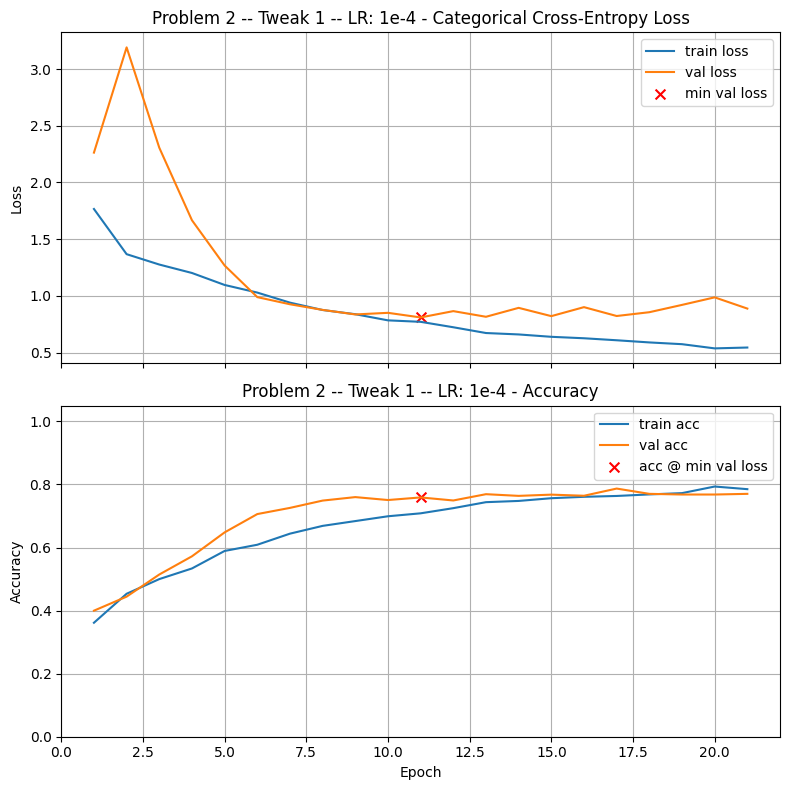

Final Training Loss:            0.5454
Final Training Accuracy:        0.7851
Final Validation Loss:          0.8887
Final Validation Accuracy:      0.7702
Minimum Validation Loss:        0.8106 (Epoch 11)
Validation Accuracy @ Min Loss: 0.7588

Test Loss: 0.7999
Test Accuracy: 0.7717

Validation-Test Gap (accuracy): 0.012849

Execution Time: 00:01:27


In [25]:
# Adjusing LR

he = initializers.HeNormal()                                # best initializer for relu

model_batch_lr= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_batch_lr, lr_schedule=1e-4, title="Problem 2 -- Tweak 1 -- LR: 1e-4")


Problem 2 -- Tweak 2 -- Changing Conv2D Width



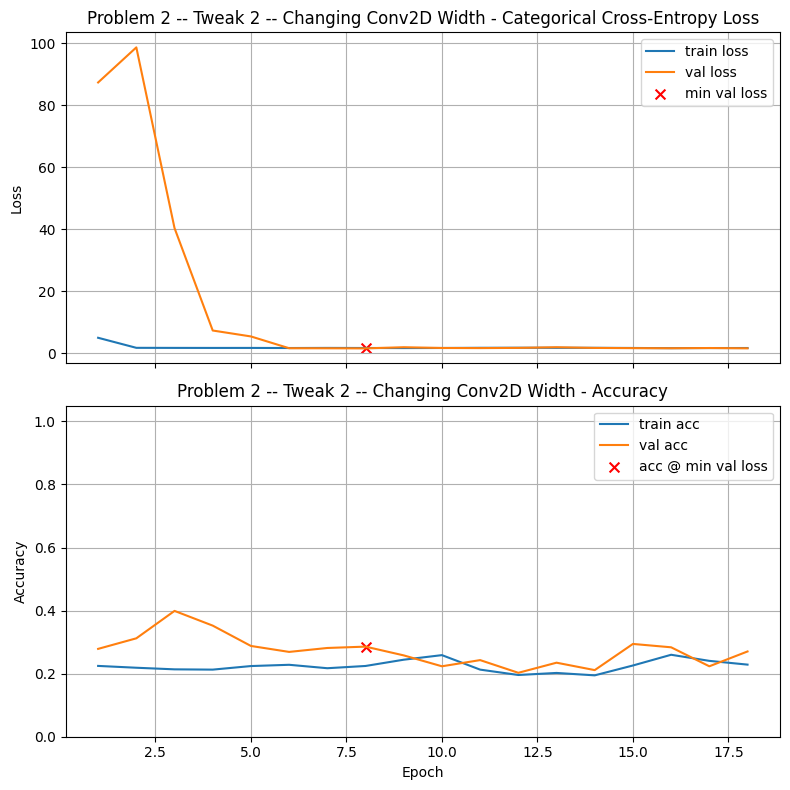

Final Training Loss:            1.7091
Final Training Accuracy:        0.2286
Final Validation Loss:          1.6110
Final Validation Accuracy:      0.2704
Minimum Validation Loss:        1.5911 (Epoch 8)
Validation Accuracy @ Min Loss: 0.2857

Test Loss: 1.6057
Test Accuracy: 0.2770

Validation-Test Gap (accuracy): 0.008714

Execution Time: 00:02:19


In [26]:
# Changing Conv2D Width

he = initializers.HeNormal()                                # best initializer for relu

model_batch_convwidth= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_batch_convwidth,title="Problem 2 -- Tweak 2 -- Changing Conv2D Width")


Problem 2 -- Tweak 3 -- Adding a Conv2D Layer



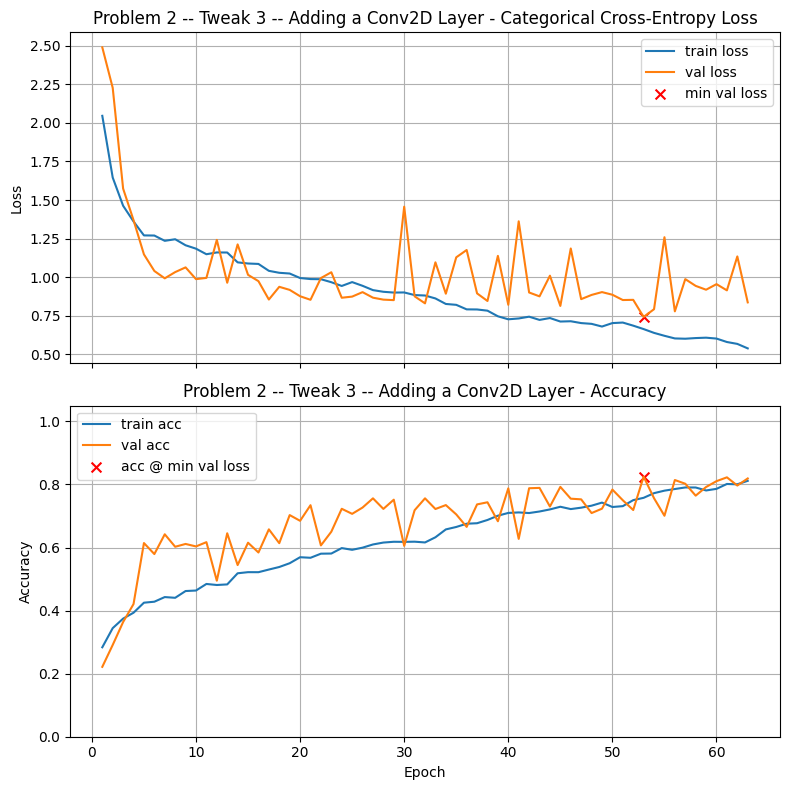

Final Training Loss:            0.5392
Final Training Accuracy:        0.8115
Final Validation Loss:          0.8372
Final Validation Accuracy:      0.8190
Minimum Validation Loss:        0.7430 (Epoch 53)
Validation Accuracy @ Min Loss: 0.8247

Test Loss: 0.6742
Test Accuracy: 0.8330

Validation-Test Gap (accuracy): 0.008276

Execution Time: 00:04:33


In [27]:
# Adding a Conv2D Layer

he = initializers.HeNormal()                                # best initializer for relu

model_batch_convadd= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_batch_convadd,title="Problem 2 -- Tweak 3 -- Adding a Conv2D Layer")


Problem 2 -- Tweak 4 -- Dense: 32



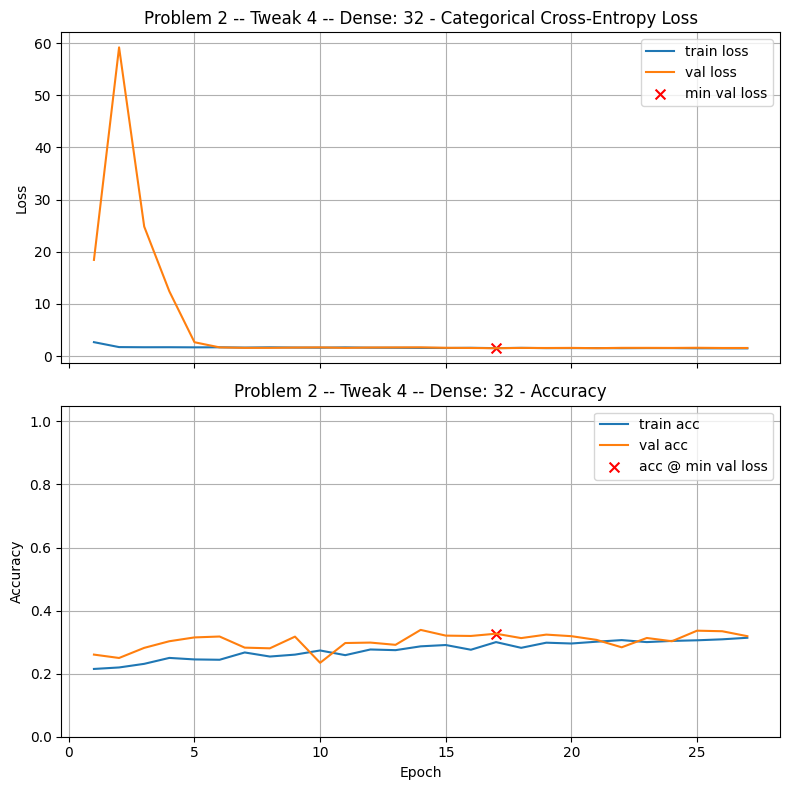

Final Training Loss:            1.4932
Final Training Accuracy:        0.3138
Final Validation Loss:          1.5678
Final Validation Accuracy:      0.3188
Minimum Validation Loss:        1.5263 (Epoch 17)
Validation Accuracy @ Min Loss: 0.3267

Test Loss: 1.5049
Test Accuracy: 0.3160

Validation-Test Gap (accuracy): 0.010683

Execution Time: 00:01:47


In [28]:
# Changing Width of Dense

he = initializers.HeNormal()                                # best initializer for relu

model_batch_dense= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(32, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_batch_dense,title="Problem 2 -- Tweak 4 -- Dense: 32")


Problem 2 -- Tweak 5 -- L2 Regularization: 1e-5



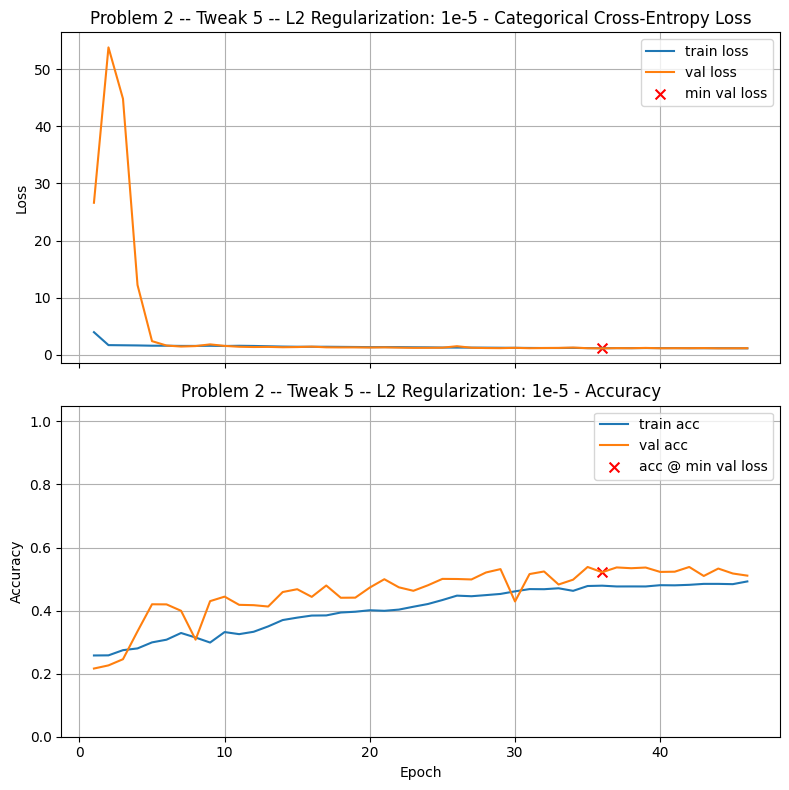

Final Training Loss:            1.1304
Final Training Accuracy:        0.4925
Final Validation Loss:          1.1498
Final Validation Accuracy:      0.5109
Minimum Validation Loss:        1.1218 (Epoch 36)
Validation Accuracy @ Min Loss: 0.5216

Test Loss: 1.0990
Test Accuracy: 0.5130

Validation-Test Gap (accuracy): 0.008553

Execution Time: 00:02:55


In [29]:
# Adding L2 Regularization

he = initializers.HeNormal()                                # best initializer for relu
l2reg = regularizers.l2(1e-5)

model_batch_l2reg= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he, kernel_regularizer=l2reg),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_batch_l2reg,title="Problem 2 -- Tweak 5 -- L2 Regularization: 1e-5")


Problem 2 -- Tweak 6 -- Dropout: 0.3



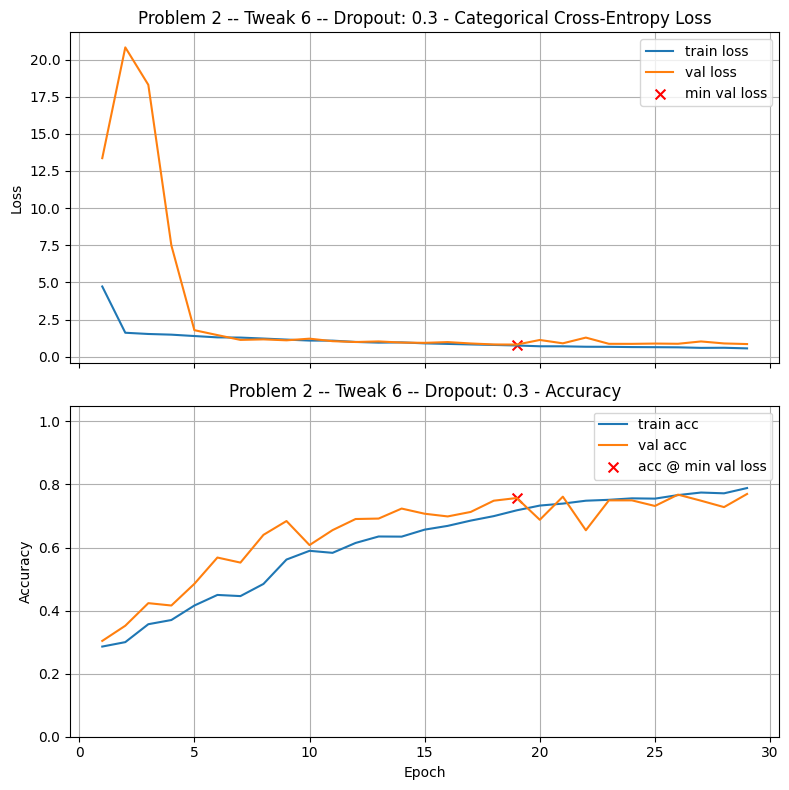

Final Training Loss:            0.5660
Final Training Accuracy:        0.7886
Final Validation Loss:          0.8567
Final Validation Accuracy:      0.7699
Minimum Validation Loss:        0.8213 (Epoch 19)
Validation Accuracy @ Min Loss: 0.7570

Test Loss: 0.8153
Test Accuracy: 0.7567

Validation-Test Gap (accuracy): 0.000369

Execution Time: 00:01:55


In [30]:
# Modify Dropout Rate

he = initializers.HeNormal()                                # best initializer for relu

model_batch_dropout= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_batch_dropout,title="Problem 2 -- Tweak 6 -- Dropout: 0.3")

In [31]:
print_results()

Problem 2 -- Tweak 3 -- Adding a Conv2D Layer	0.8247	53
Problem 1 -- Tweak 2 -- Changing Conv2D widths	0.7898	22
Problem 1 -- Tweak 5.1 -- L2 Reg: 1e-4  	0.7688	13
Problem 1 -- Tweak 1.2 -- lr: 1e-5      	0.7652	105
Problem 1 -- Tweak 3 -- Adding an extra Conv2D layer	0.7645	19
Problem 2 -- Tweak 1 -- LR: 1e-4        	0.7588	11
Problem 2 -- Tweak 6 -- Dropout: 0.3    	0.7570	19
Baseline Model                          	0.7403	19
Problem 1 -- Tweak 6 -- Dropout: 0.3    	0.7278	18
Problem 1 -- Tweak 4.3 -- Dense: 128    	0.7246	6
Problem 1 -- Tweak 5.2 -- L2 Reg: 3e-5  	0.7114	18
Problem 2 -- Baseline Batch Normalization	0.7061	58
Problem 1 -- Tweak 1.1 -- lr: 1e-4      	0.6288	46
Problem 2 -- Tweak 5 -- L2 Regularization: 1e-5	0.5216	36
Problem 1 -- Tweak 4.1 -- Dense: 32     	0.4247	42
Problem 2 -- Tweak 4 -- Dense: 32       	0.3267	17
Problem 2 -- Tweak 2 -- Changing Conv2D Width	0.2857	8
Problem 1 -- Tweak 4.2 -- Dense: 16     	0.1792	12


### Graded Questions

In [32]:
# Set a2a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a2a = 3             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [33]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2a = {a2a}')


a2a = 3


In [34]:
# Set a2b to the validation accuracy found by the choice specified in Question a2a (your best model for this problem)

a2b = 0.8247             # Replace 0.0 with your answer

In [35]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2b = {a2b:.4f}')

a2b = 0.8247


## Problem Three: Global Average Pooling

As we saw in this week's Coding Video,
**Global Average Pooling** is a simple layer that replaces the `Flatten → Dense` part of a CNN (please review that part of the Coding Notebook, which contains a description of this important technique).

In practice, swapping `Flatten` for `GlobalAveragePooling2D` often improves stability and validation performance — definitely worth considering!


**Task:**
Modify your best model from Problems 1 & 2 to use a `GlobalAveragePooling2D()` layer instead of a flatten-and-dense block.

**Next Steps:**

* Replace the sequence between the last `Conv2D` and output layers, for example:

     
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(64, activation='relu', kernel_initializer=initializers.HeNormal()),
          Dropout(0.5),   

  with a single `GlobalAveragePooling2D()` layer.
* Train the model and observe how performance and training curves change.
* Try at least one of tweaks from Problem 1 to see if you can improve your results in this new design.
* Compare results and answer the graded questions.

**Optional:**
Experiment with `GlobalMaxPooling2D()` as an alternative and compare its behavior to `GlobalAveragePooling2D()`.




Problem 3 -- GAP Baseline



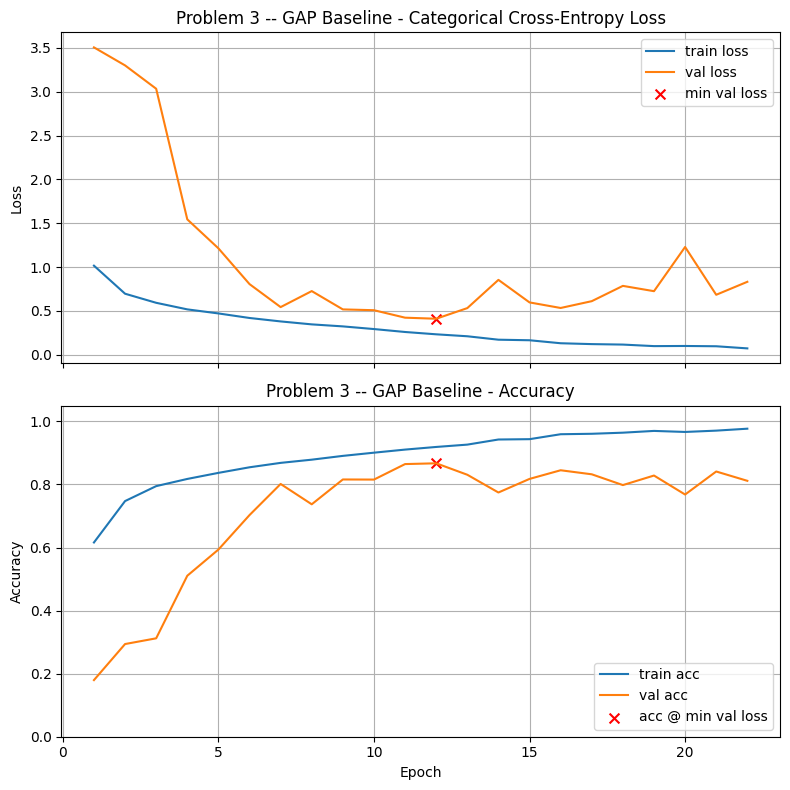

Final Training Loss:            0.0722
Final Training Accuracy:        0.9768
Final Validation Loss:          0.8317
Final Validation Accuracy:      0.8115
Minimum Validation Loss:        0.4104 (Epoch 12)
Validation Accuracy @ Min Loss: 0.8671

Test Loss: 0.4053
Test Accuracy: 0.8610

Validation-Test Gap (accuracy): 0.006118

Execution Time: 00:01:31


In [85]:
# Your code here, add additional cells if you wish

he = initializers.HeNormal()                                # best initializer for relu

model_gap= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap,title="Problem 3 -- GAP Baseline")


Problem 3 -- Tweak 1.1 -- LR: 1e-4



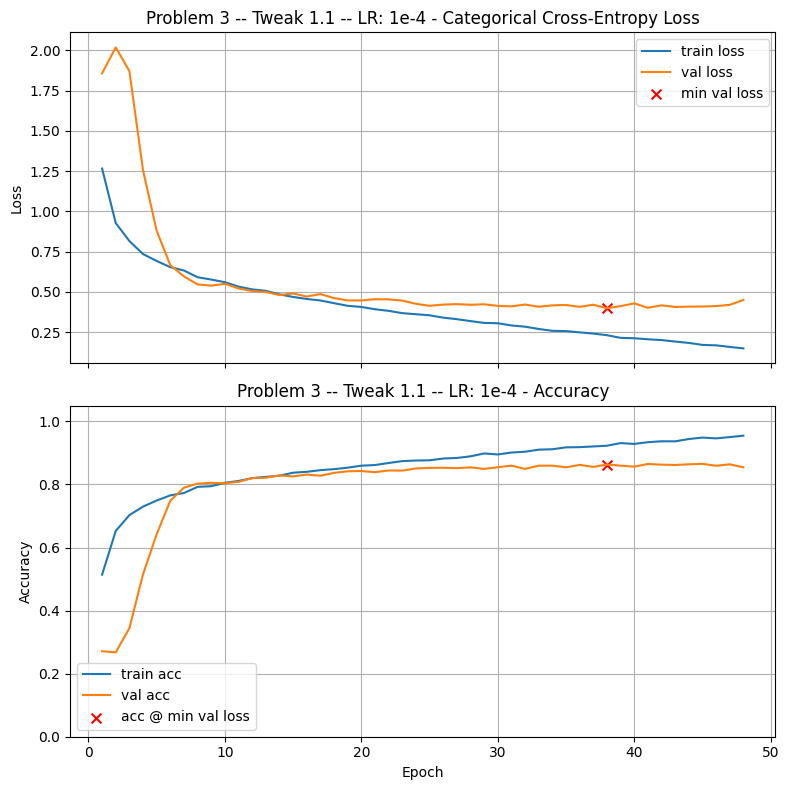

Final Training Loss:            0.1498
Final Training Accuracy:        0.9547
Final Validation Loss:          0.4504
Final Validation Accuracy:      0.8543
Minimum Validation Loss:        0.3990 (Epoch 38)
Validation Accuracy @ Min Loss: 0.8632

Test Loss: 0.3749
Test Accuracy: 0.8710

Validation-Test Gap (accuracy): 0.007801

Execution Time: 00:02:28


In [86]:
# Adjusting LR

he = initializers.HeNormal()                                # best initializer for relu

model_gap_lr1= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap_lr1, lr_schedule=1e-4, title="Problem 3 -- Tweak 1.1 -- LR: 1e-4")


Problem 3 -- Tweak 1.2 -- LR: 1e-5



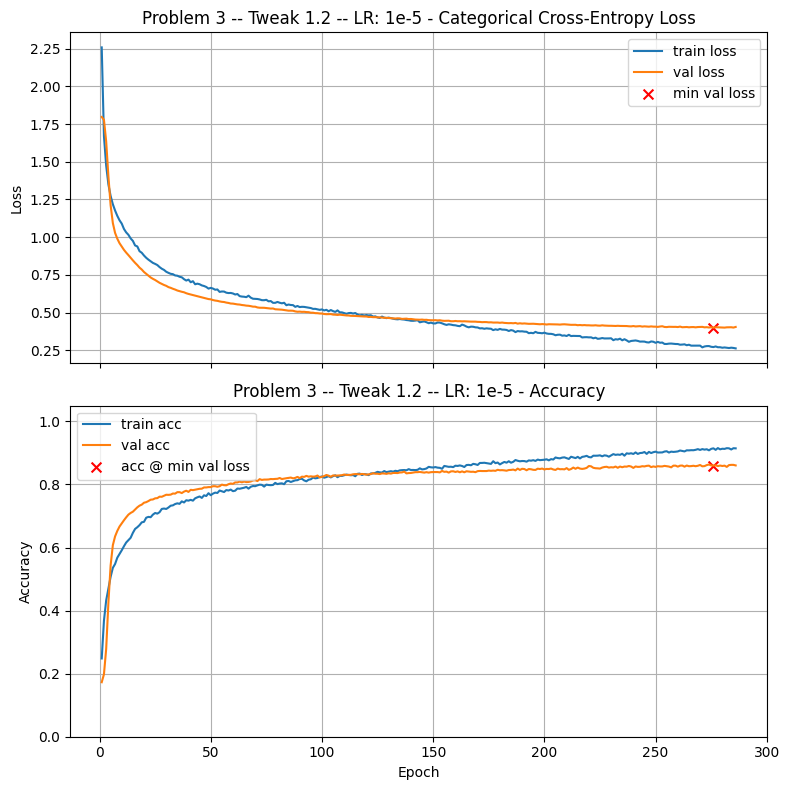

Final Training Loss:            0.2628
Final Training Accuracy:        0.9145
Final Validation Loss:          0.4049
Final Validation Accuracy:      0.8603
Minimum Validation Loss:        0.4005 (Epoch 276)
Validation Accuracy @ Min Loss: 0.8600

Test Loss: 0.3659
Test Accuracy: 0.8697

Validation-Test Gap (accuracy): 0.009674

Execution Time: 00:13:06


In [87]:
# Adjusting LR

he = initializers.HeNormal()                                # best initializer for relu

model_gap_lr2= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap_lr2, lr_schedule=1e-5, title="Problem 3 -- Tweak 1.2 -- LR: 1e-5")


Problem 3 -- Tweak 2 -- Changing Conv2D Width



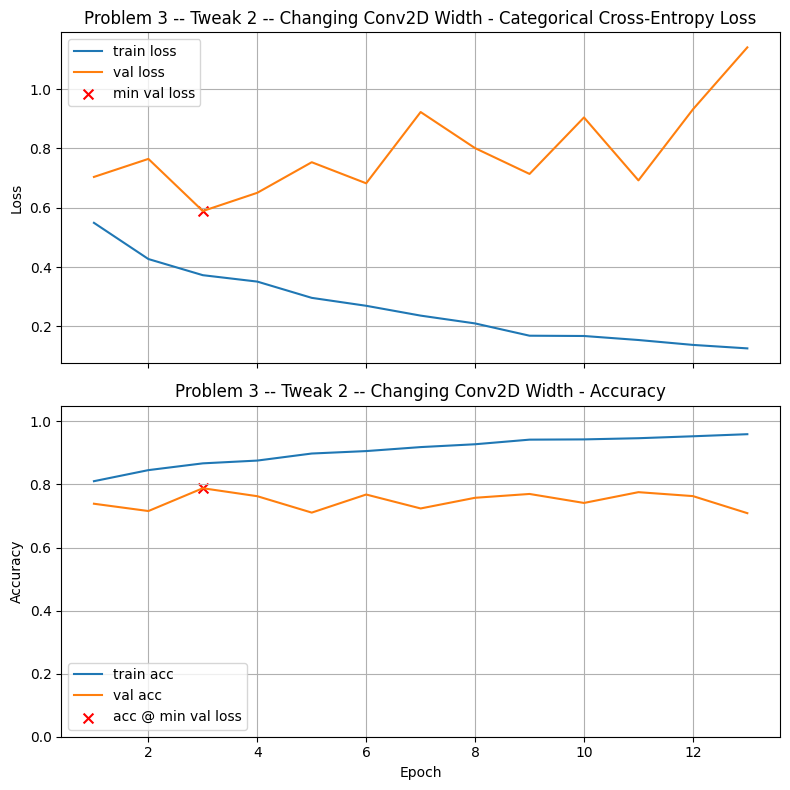

Final Training Loss:            0.1258
Final Training Accuracy:        0.9594
Final Validation Loss:          1.1405
Final Validation Accuracy:      0.7089
Minimum Validation Loss:        0.5889 (Epoch 3)
Validation Accuracy @ Min Loss: 0.7880

Test Loss: 0.5801
Test Accuracy: 0.7990

Validation-Test Gap (accuracy): 0.010970

Execution Time: 00:00:54


In [88]:
# Changing Width of Conv2D

he = initializers.HeNormal()                                # best initializer for relu

model_gap_convwidth= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(512, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap_lr1, title="Problem 3 -- Tweak 2 -- Changing Conv2D Width")


Problem 3 -- Tweak 3.1 -- Removing Conv2D Layer



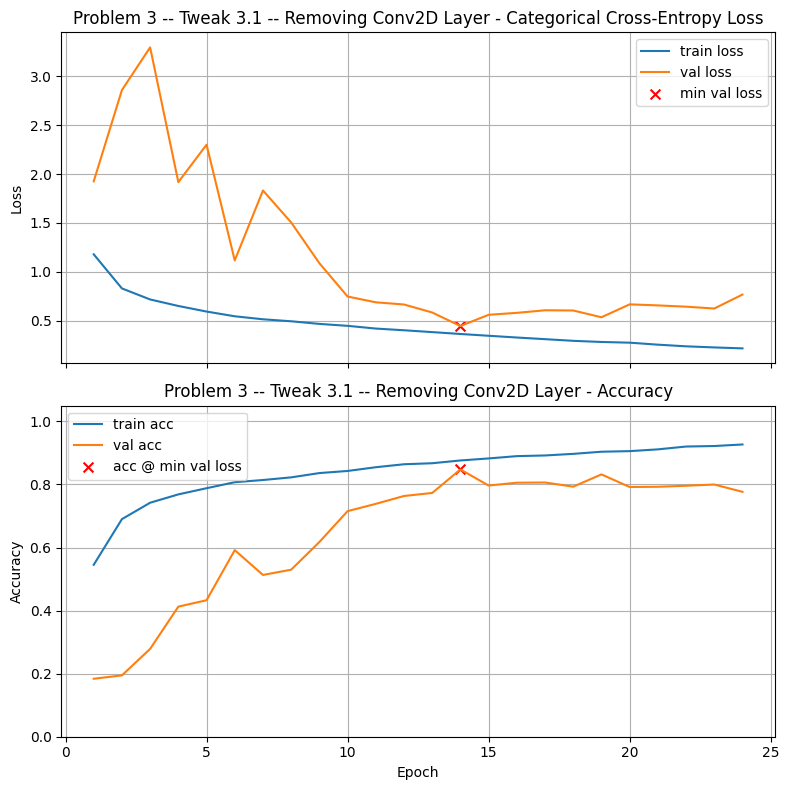

Final Training Loss:            0.2148
Final Training Accuracy:        0.9268
Final Validation Loss:          0.7661
Final Validation Accuracy:      0.7766
Minimum Validation Loss:        0.4436 (Epoch 14)
Validation Accuracy @ Min Loss: 0.8475

Test Loss: 0.4218
Test Accuracy: 0.8527

Validation-Test Gap (accuracy): 0.005143

Execution Time: 00:01:27


In [89]:
# Removing Conv2D layer

he = initializers.HeNormal()                                # best initializer for relu

model_gap_convrem= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap_convrem, title="Problem 3 -- Tweak 3.1 -- Removing Conv2D Layer")


Problem 3 -- Tweak 3.2 -- Adding Conv2D Layer



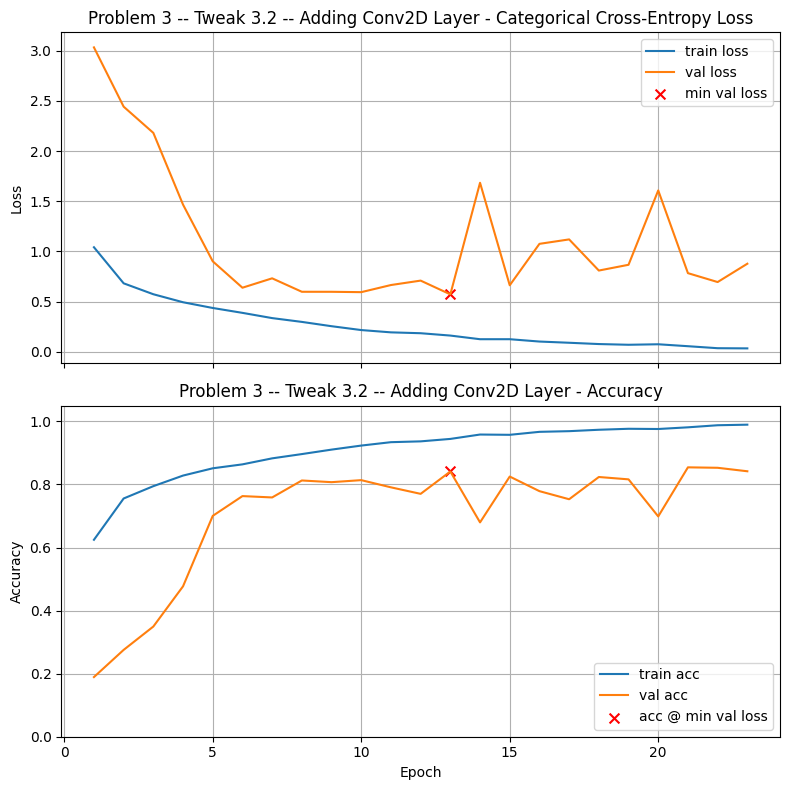

Final Training Loss:            0.0334
Final Training Accuracy:        0.9896
Final Validation Loss:          0.8773
Final Validation Accuracy:      0.8418
Minimum Validation Loss:        0.5719 (Epoch 13)
Validation Accuracy @ Min Loss: 0.8411

Test Loss: 0.5686
Test Accuracy: 0.8407

Validation-Test Gap (accuracy): 0.000445

Execution Time: 00:01:41


In [90]:
# Adding Conv2D layer

he = initializers.HeNormal()                                # best initializer for relu

model_gap_conv2add= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(512, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap_conv2add, title="Problem 3 -- Tweak 3.2 -- Adding Conv2D Layer")


Problem 3 -- Tweak 4 -- Dense: 32



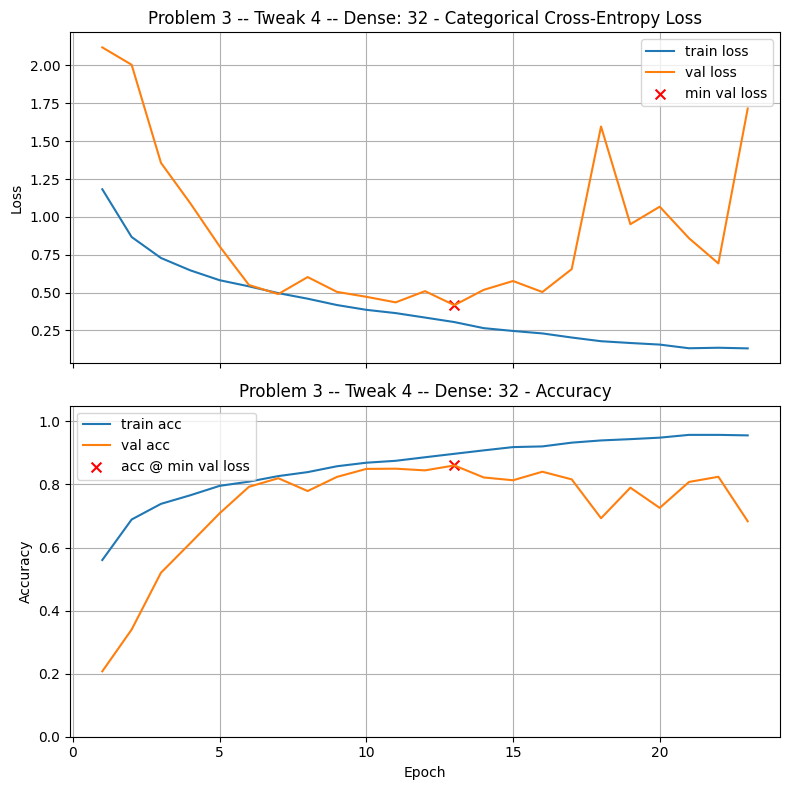

Final Training Loss:            0.1318
Final Training Accuracy:        0.9556
Final Validation Loss:          1.7157
Final Validation Accuracy:      0.6833
Minimum Validation Loss:        0.4169 (Epoch 13)
Validation Accuracy @ Min Loss: 0.8603

Test Loss: 0.3976
Test Accuracy: 0.8677

Validation-Test Gap (accuracy): 0.007318

Execution Time: 00:01:30


In [91]:
# Changing Dense width

he = initializers.HeNormal()                                # best initializer for relu

model_gap_dense= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(32, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap_dense, title="Problem 3 -- Tweak 4 -- Dense: 32")


Problem 3 -- Tweak 5.1 -- L2 Reg: 1e-4



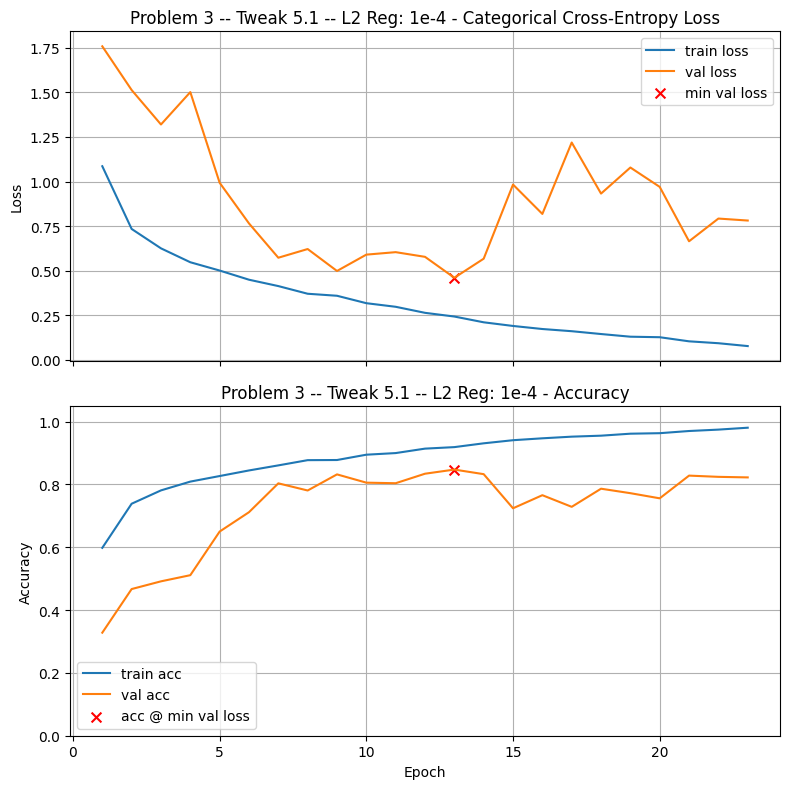

Final Training Loss:            0.0780
Final Training Accuracy:        0.9808
Final Validation Loss:          0.7813
Final Validation Accuracy:      0.8226
Minimum Validation Loss:        0.4607 (Epoch 13)
Validation Accuracy @ Min Loss: 0.8475

Test Loss: 0.4317
Test Accuracy: 0.8627

Validation-Test Gap (accuracy): 0.015143

Execution Time: 00:01:22


In [92]:
# Adding L2 Regularization

he = initializers.HeNormal()                                # best initializer for relu
l2reg = regularizers.l2(1e-4)

model_gap_l2reg1= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he, kernel_regularizer=l2reg),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap_l2reg1,title="Problem 3 -- Tweak 5.1 -- L2 Reg: 1e-4")


Problem 3 -- Tweak 5.2 -- L2 Reg: 1e-5



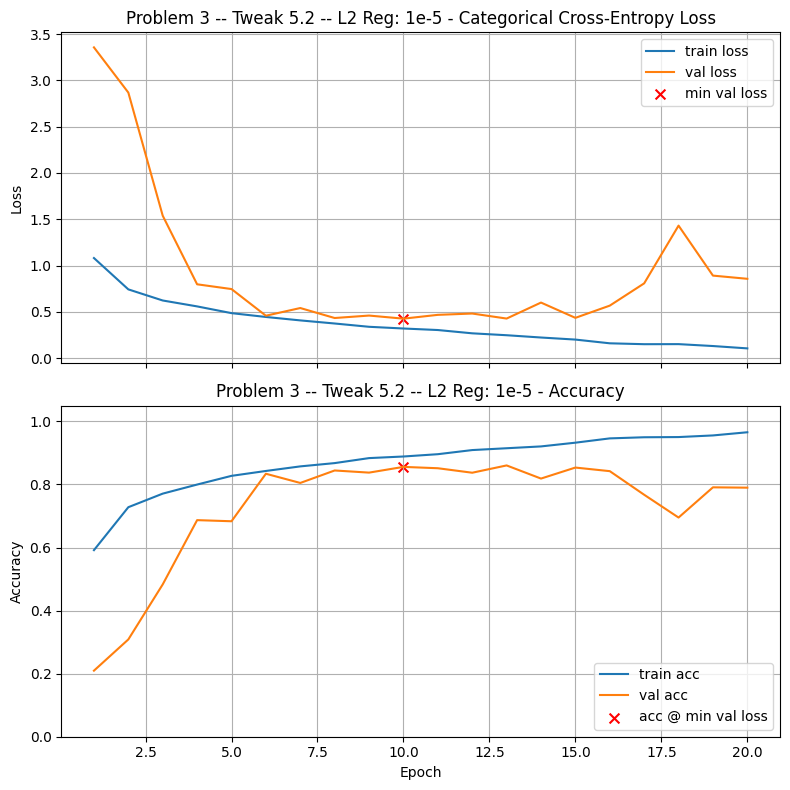

Final Training Loss:            0.1062
Final Training Accuracy:        0.9655
Final Validation Loss:          0.8574
Final Validation Accuracy:      0.7898
Minimum Validation Loss:        0.4272 (Epoch 10)
Validation Accuracy @ Min Loss: 0.8557

Test Loss: 0.4071
Test Accuracy: 0.8643

Validation-Test Gap (accuracy): 0.008615

Execution Time: 00:01:14


In [93]:
# Adding L2 Regularization

he = initializers.HeNormal()                                # best initializer for relu
l2reg = regularizers.l2(1e-5)

model_gap_l2reg2= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he, kernel_regularizer=l2reg),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap_l2reg2,title="Problem 3 -- Tweak 5.2 -- L2 Reg: 1e-5")


Problem 3 -- Tweak 6 -- Dropout: 0.3



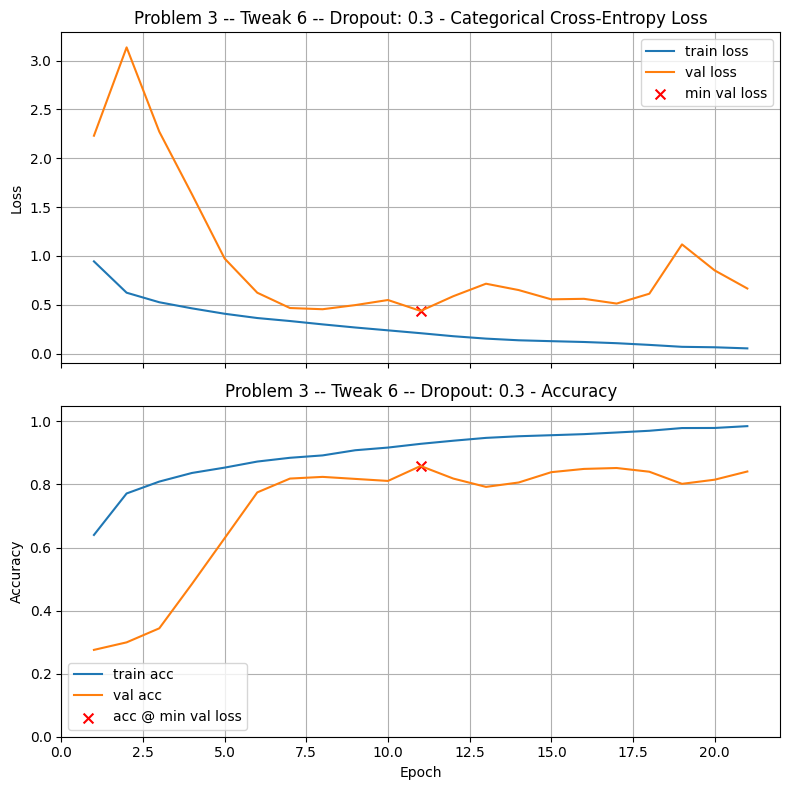

Final Training Loss:            0.0528
Final Training Accuracy:        0.9849
Final Validation Loss:          0.6658
Final Validation Accuracy:      0.8411
Minimum Validation Loss:        0.4363 (Epoch 11)
Validation Accuracy @ Min Loss: 0.8586

Test Loss: 0.4579
Test Accuracy: 0.8537

Validation-Test Gap (accuracy): 0.004901

Execution Time: 00:01:16


In [94]:
# Modify Dropout Rate

he = initializers.HeNormal()                                # best initializer for relu

model_gap_dropout= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap_dropout,title="Problem 3 -- Tweak 6 -- Dropout: 0.3")

In [95]:
print_results()

Problem 3 -- GAP Baseline               	0.8671	12
Problem 3 -- Tweak 1.1 -- LR: 1e-4      	0.8632	38
Problem 3 -- Tweak 4 -- Dense: 32       	0.8603	13
Problem 3 -- Tweak 1.2 -- LR: 1e-5      	0.8600	276
Problem 3 -- Tweak 6 -- Dropout: 0.3    	0.8586	11
Problem 3 -- Tweak 5.2 -- L2 Reg: 1e-5  	0.8557	10
Problem 3 -- Tweak 3.1 -- Removing Conv2D Layer	0.8475	14
Problem 3 -- Tweak 5.1 -- L2 Reg: 1e-4  	0.8475	13
Problem 3 -- Tweak 3.2 -- Adding Conv2D Layer	0.8411	13
Problem 2 -- Tweak 3.2 -- Adding a Conv2D Layer	0.8351	11
Problem 2 -- Tweak 6 -- Dropout: 0.3    	0.8215	21
Problem 2 -- Baseline Batch Normalization	0.7934	15
Problem 3 -- Tweak 2 -- Changing Conv2D Width	0.7880	3
Problem 1 -- Tweak 3 -- Adding an extra Conv2D layer	0.7798	25
Problem 2 -- Tweak 1 -- LR: 1e-4        	0.7773	8
Problem 2 -- Tweak 5 -- L2 Regularization: 1e-5	0.7738	53
Problem 1 -- Tweak 1.2 -- lr: 1e-5      	0.7706	103
Problem 1 -- Tweak 2 -- Changing Conv2D widths	0.7670	13
Problem 1 -- Tweak 5.1 -- L2 Reg

### Graded Questions

In [96]:
# Set a3a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a3a = 0             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [97]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3a = {a3a}')


a3a = 0


In [98]:
# Set a3b to the validation accuracy found by the choice specified in Question a3a (your best model for this problem)

a3b = 0.8671             # Replace 0.0 with your answer

In [99]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3b = {a3b:.4f}')

a3b = 0.8671


## Problem Four: ReduceLROnPlateau

`ReduceLROnPlateau` is a widely used learning rate scheduling technique. It monitors a validation metric (usually `val_loss`) and reduces the learning rate when progress stalls, allowing the model to refine training at a smaller step size. This is one of the most useful scheduling tools (along with the essential Early Stopping) to have in your toolbox.

**Task:**
Augment your best model found so far in Problems 1 - 3 with the `ReduceLROnPlateau` callback during training.

**Next Steps:**

* Add the callback parameter to `train_and_test`:

  ```python
  callbacks=[reduce_lr]
  ```

* Start with **`factor=0.5`** (monitor `val_loss`, `patience=2–3`, `cooldown=1`, `min_lr=1e-5` for Adam).
* **Practical playbook:**

  * If plateau persists after one reduction → try **`factor=0.3`**, then **`0.2`**.
  * If a reduction hurts validation noticeably → try **`factor=0.7–0.8`** or increase **`patience`**.
  * Leave **`cooldown=1`** unless you see too-frequent drops.
* Experiment with **`patience` = 3, 5, 8** and **`min_delta` = `1e-4` vs `1e-3`** to gauge sensitivity.
* Choose the configuration with the best validation results—or note that ReduceLROnPlateau didn’t help (rare!).
* Answer the graded questions.




Problem 4 -- Factor = 0.5



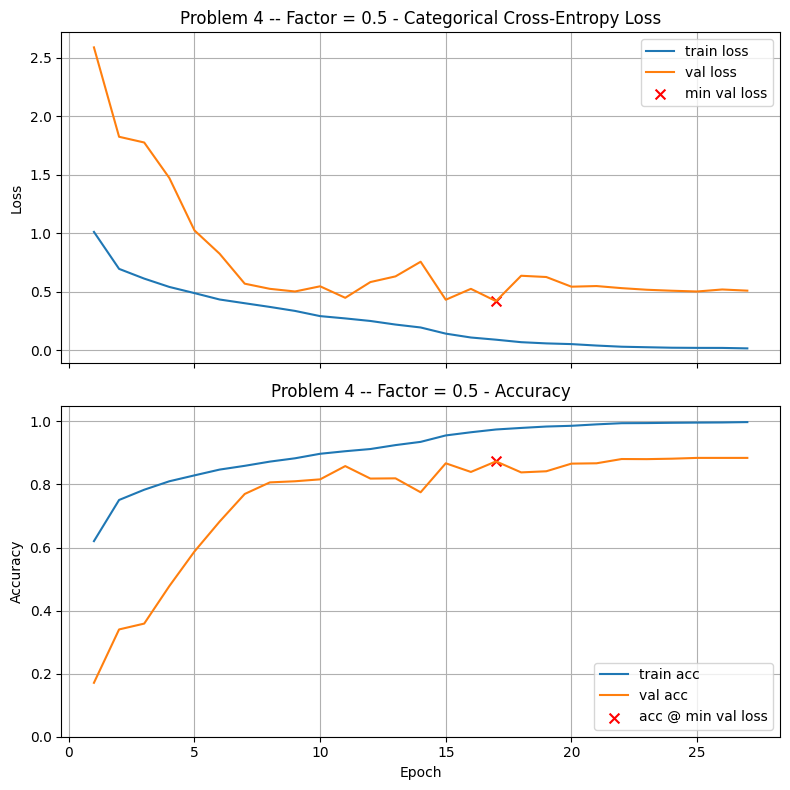

Final Training Loss:            0.0162
Final Training Accuracy:        0.9978
Final Validation Loss:          0.5099
Final Validation Accuracy:      0.8842
Minimum Validation Loss:        0.4201 (Epoch 17)
Validation Accuracy @ Min Loss: 0.8732

Test Loss: 0.4184
Test Accuracy: 0.8727

Validation-Test Gap (accuracy): 0.000508

Execution Time: 00:01:32


In [101]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=1,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

# Your code here, add more cells as needed

he = initializers.HeNormal()                                # best initializer for relu

model_rlr= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_rlr,title="Problem 4 -- Factor = 0.5", callbacks=[reduce_lr])


Problem 4 -- Factor = 0.3



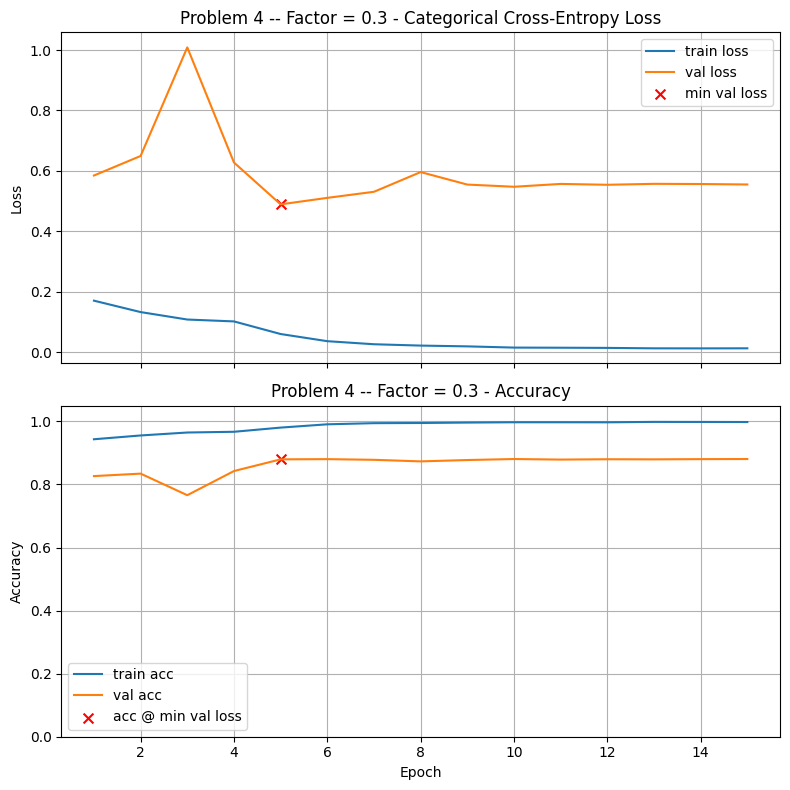

Final Training Loss:            0.0130
Final Training Accuracy:        0.9980
Final Validation Loss:          0.5551
Final Validation Accuracy:      0.8807
Minimum Validation Loss:        0.4894 (Epoch 5)
Validation Accuracy @ Min Loss: 0.8796

Test Loss: 0.4729
Test Accuracy: 0.8807

Validation-Test Gap (accuracy): 0.001080

Execution Time: 00:01:00


In [102]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.3,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=1,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

# Your code here, add more cells as needed

he = initializers.HeNormal()                                # best initializer for relu

model_rlr= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_gap,title="Problem 4 -- Factor = 0.3", callbacks=[reduce_lr])

In [1]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=1,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

he = initializers.HeNormal()                                # best initializer for relu

model_rlr= models.Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_rlr,title="Problem 4 -- Factor = 0.5", callbacks=[reduce_lr])

NameError: name 'ReduceLROnPlateau' is not defined

### Graded Questions

In [58]:
# Set a4a to the factor parameter which gave the best validation accuracy at the point of minimum validation loss

a4a = 0.0             # Replace with your best factor value, or leave at 0.0 if reduce on plateau did not help at all

In [59]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4a = {a4a:.2f}')

a4a = 0.00


In [60]:
# Set a4b to the validation accuracy found by the choice specified in Question a4a (your best model for this problem)

a4b = 0.0             # Replace 0.0 with your answer

In [61]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4b = {a4b:.4f}')

a4b = 0.0000


## Problem Five: A Very Deep CNN (VGG-16 Style)

 We will now experiment with the VGG-16 design introduced in the Coding Notebook and Video and see how it does on this dataset. For a beautiful description of the model and its significance, see:

        https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/

![Screenshot 2025-09-19 at 6.50.24 AM.png](attachment:62fa0824-bb06-4663-a6a5-da8cca8f4ab3.png)


In this exercise you’ll **only vary the learning rate**. Don’t change any other hyperparameters. Your goal is to observe how LR affects convergence speed, stability, and final validation performance compared to your smaller baselines. This sets up next week’s **transfer learning** with pretrained models.

#### Starting point

* Optimizer: **Adam**
* **Recommended LR to start:** `1e-3`(Adam default)

#### What LR values to try (coarse → fine)

Try a short sweep like:

```
[1e-2, 3e-3, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
```

Then, as time allows,  zoom in around the best.

#### How to judge “best”

* Primary: **best validation accuracy at epoch of lowest validation loss**
* Secondary: **time-to-best** (fewer epochs to reach a strong val metric) and **curve shape** (smooth vs. noisy/oscillatory).

#### What symptoms mean

* **LR too high:** training loss spikes or oscillates; val metrics erratic, occasional NaNs/divergence.
* **LR too low:** very slow improvement; long flat regions; never reaches your smaller models’ performance.


**Tip:** Keep LR **constant** during each run (don’t schedule) so you isolate its effect.



In [62]:
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)   # set to None to disable or tweak the value

model_vgg_16 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    # Block 1
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 4 (NO MaxPool here -> leaves 3×3×512)
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),

    # Global pooling meaningfully summarizes the 3×3 map
    layers.GlobalAveragePooling2D(),   # swap to GlobalMaxPooling2D() to compare

    # Compact head
    layers.Dense(256, activation='relu', kernel_initializer=he,
                 kernel_regularizer=l2reg),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Uncomment the next line to run

# train_and_test(model_vgg_16,lr_schedule=1e-3,title="VGG-style Large")


### Graded Questions

In [63]:
# Set a5a to the learning rate which gave the best validation accuracy at the point of minimum validation loss

a5a = 0.0             # Replace with your best learning rate

In [64]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5a = {a5a:.8f}')

a5a = 0.00000000


In [65]:
# Set a5b to the validation accuracy found by the choice specified in Question a5a (your best model for this problem)

a5b = 0.0              # Replace 0.0 with your answer

In [66]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5b = {a5b:.4f}')

a5b = 0.0000


## All Results

This will print out the results from all experiments, with titles as keys. I use this all the time to keep track of experiments!

In [67]:
print_results()

Problem 1 -- Tweak 3 -- Adding an extra Conv2D layer	0.7798	25
Problem 1 -- Tweak 1.2 -- lr: 1e-5      	0.7706	103
Problem 1 -- Tweak 2 -- Changing Conv2D widths	0.7670	13
Problem 1 -- Tweak 5.1 -- L2 Reg: 1e-4  	0.7545	13
Problem 1 -- Tweak 5.2 -- L2 Reg: 3e-5  	0.7471	24
Baseline Model                          	0.7392	18
Problem 1 -- Tweak 4.3 -- Dense: 128    	0.7378	7
Problem 1 -- Tweak 6 -- Dropout: 0.3    	0.6890	15
Problem 1 -- Tweak 1.1 -- lr: 1e-4      	0.6327	54
Problem 1 -- Tweak 4.1 -- Dense: 32     	0.5675	48
Problem 1 -- Tweak 4.2 -- Dense: 16     	0.1792	12
